In [1]:
import pandas as pd
import numpy as np
import datetime

import matplotlib.pyplot as plt

## Apple Mobility Data
***

#### Functions:

In [86]:
def save_AMD_Italy():
    '''
    Generates the reduced CSV to speed up the loading time
    '''
    df = pd.read_csv("DATA/AMD/applemobilitytrends-2022-02-10.csv")
    df_out = applyfilter(df, {"country"  : ["Italy"], 
                              "geo_type" : ["sub-region"]})
    df_out.drop(["geo_type", "alternative_name", "sub-region", "country"], 1, inplace=True)
    
    # Adding the mobility trend for the whole Italy weighting the data with the
    # population density
    region_name = np.unique(list(df_out['region'].values))
    pop_density = np.array([118, 201, 38, 151, 66, 79, 54, 122, 411, 198, 333, 280, 418, 159, 66, 168, 187, 161, 102, 265]) # ISTAT 01/01/2121
    weight_dict = { key : value for key,value in zip(region_name, pop_density)}
    walking_values = np.zeros(len(df_out.columns)-2)
    driving_values = np.zeros(len(df_out.columns)-2)
    driving_norm, walking_norm = 0, 0
    # The following try except are implemented due to the fact that some regions lack the walking data
    for region in region_name:
        try:
            driving_values += applyfilter(df_out, {"region" : [region], "transportation_type" : ["driving"]}).iloc[:,2:].values.flatten() * weight_dict[region]
        except Exception:
            pass
        else:
            driving_norm += weight_dict[region]
        
        try:
            walking_values += applyfilter(df_out, {"region" : [region], "transportation_type" : ["walking"]}).iloc[:,2:].values.flatten() * weight_dict[region]
        except Exception:
            pass
        else:
            walking_norm += weight_dict[region]
    #print(driving_norm,walking_norm)
    df_tmp = pd.DataFrame([["Italy", "driving", *driving_values/driving_norm],
                           ["Italy", "walking", *walking_values/walking_norm]], columns=df_out.columns)
    df_out = pd.concat([df_out, df_tmp], ignore_index=True)
    df_out.to_csv("DATA/AMD/applemobilitytrends_ITA-2022-02-10.csv", index=False)

def load_AMD_Italy():
    '''
    Load the AMD referred to Italy and return the dataframe and the dates, 
    and eventually saves the list of all possible cities/regions
    '''
    df = pd.read_csv("DATA/AMD/applemobilitytrends_ITA-2022-02-10.csv")
    dates_str  = df.columns[2:] # list of sting
    return df, dates_str

def applyfilter(df, dictionary):
    '''
    Filter the dataframe according to the dictionary: the values needs to be a list
    The order matter
    '''
    df_out = df.copy()
    for key in dictionary.keys():
        sub_df = [df_out.loc[df_out[key] == val] for val in dictionary[key]]
        df_out = pd.concat(sub_df, ignore_index=True)

    return df_out

def fill_missing(df):
    '''
    AMD driving are missing for the 2020-05-11, 2020-05-12 
    AMD are missing for the 2021-03-12
    '''
    df_driv = df.loc[df["transportation_type"] == "driving", ["2020-05-10","2020-05-13"]]
    values = (df_driv["2020-05-10"].values + df_driv["2020-05-13"].values)/2
    df.loc[df["transportation_type"] == "driving", "2020-05-11"] = values
    df.loc[df["transportation_type"] == "driving", "2020-05-12"] = values
    df["2021-03-12"] = (df["2021-03-11"] + df["2021-03-13"])/2

def transform_week_RAVG(dataframe, cols, window=7):
    '''
    Substitute the mobility data with it's rolling average
    '''
    values = dataframe[cols].values
    RAVG = np.array([values[:,ii-window:ii].sum(axis=1)/window for ii in np.arange(window,len(cols)+1)]).T
    dataframe[cols[:window-1]] = np.NaN
    dataframe[cols[window-1:]] = RAVG
    
def from_to(date_list, start, end):
    '''
    Return the indexes of a date list corresponding to the period between start and end
    '''
    a = list(date_list).index(start)
    b = list(date_list).index(end)
    return slice(a,b+1), np.arange(a,b+1)   # we need np because integer operation are not allowed on range object

#### Examples:

In [59]:
# Obviously needs to be run just the first time to generate the CVS
#save_AMD_Italy()
df_ita, dates_list = load_AMD_Italy()
fill_missing(df_ita)
transform_week_RAVG(df_ita, dates_list)
region_list = np.unique(df_ita["region"].values)
dates_datetime = [datetime.datetime.strptime(date, "%Y-%m-%d").date() for date in dates_list]
df_ita.head()

,region,transportation_type,2020-01-13,2020-01-14,2020-01-15,2020-01-16,2020-01-17,2020-01-18,2020-01-19,2020-01-20,...,2022-02-01,2022-02-02,2022-02-03,2022-02-04,2022-02-05,2022-02-06,2022-02-07,2022-02-08,2022-02-09,2022-02-10
0,Abruzzo Region,driving,NaN,NaN,NaN,NaN,NaN,NaN,106.295714,106.267143,...,138.440000,137.808571,137.991429,137.358571,136.084286,133.504286,134.070000,134.352857,135.762857,136.315714
1,Abruzzo Region,walking,NaN,NaN,NaN,NaN,NaN,NaN,111.790000,113.278571,...,175.931429,176.121429,174.678571,172.627143,168.042857,164.775714,163.804286,164.785714,165.158571,167.681429
2,Apulia Region,driving,NaN,NaN,NaN,NaN,NaN,NaN,106.478571,106.725714,...,129.600000,129.788571,130.055714,130.615714,131.090000,131.641429,132.187143,133.182857,134.434286,136.601429
3,Apulia Region,walking,NaN,NaN,NaN,NaN,NaN,NaN,110.544286,110.660000,...,150.231429,151.904286,152.297143,152.602857,154.515714,155.550000,155.257143,156.937143,158.192857,161.128571
4,Autonomous Region Aosta Valley,driving,NaN,NaN,NaN,NaN,NaN,NaN,138.260000,138.518571,...,184.881429,184.214286,185.864286,186.568571,183.064286,179.954286,180.338571,182.091429,183.322857,183.782857


In [25]:
print(region_list)

['Abruzzo Region' 'Apulia Region' 'Autonomous Region Aosta Valley'
 'Autonomous Region Friuli-Venezia Giulia' 'Autonomous Region Sardinia'
 'Autonomous Region Trentino-Alto Adige/Südtirol' 'Basilicata Region'
 'Calabria Region' 'Campania Region' 'Emilia-Romagna Region' 'Italy'
 'Lazio Region' 'Liguria Region' 'Lombardy Region' 'Marche Region'
 'Molise Region' 'Piedmont Region' 'Sicily Region' 'Tuscany Region'
 'Umbria Region' 'Veneto Region']


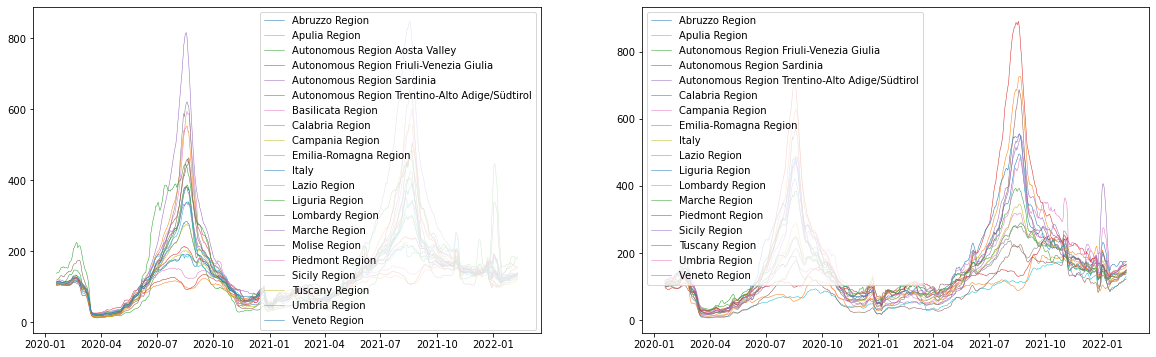

In [26]:
fig, ax = plt.subplots(1,2, figsize=[20,6])
for region in region_list:
    try:
        ax[0].plot(dates_datetime, applyfilter(df_ita, {"region" : [region]}).iloc[0,2:], label=region, linewidth=0.5)
    except Exception:
        pass
    
    try:
        ax[1].plot(dates_datetime, applyfilter(df_ita, {"region" : [region]}).iloc[1,2:], label=region, linewidth=0.5)
    except Exception:
        pass
ax[0].legend()
ax[1].legend()
plt.show()

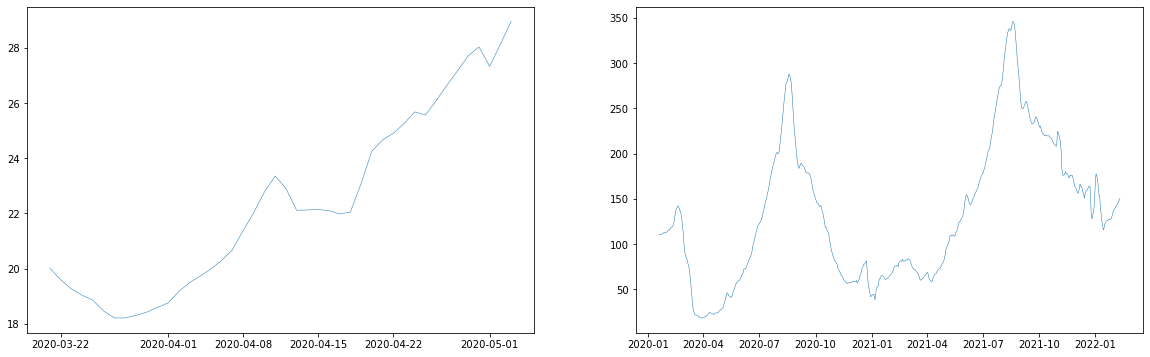

In [88]:
# To get the indexes of a given windows of time
window_slice, window_mask = from_to(dates_list,"2020-03-21","2020-05-03")  # to a list we can just apply a slice

fig, ax = plt.subplots(1,2, figsize=[20,6])

ax[0].plot(dates_datetime[window_slice], applyfilter(df_ita, {"region" : ["Italy"]}).iloc[0,window_mask+2], linewidth=0.5)

ax[1].plot(dates_datetime, applyfilter(df_ita, {"region" : ["Italy"]}).iloc[1,2:], linewidth=0.5)

#ax[0].legend()
#ax[1].legend()
plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=184d889a-a2ed-4573-89e0-8128a15d6102' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>